In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import datetime as dt


### 1. Load Dataset 
This spreadsheet is downloaded from UCI online retail dataset

In [2]:
file_path = '../data/Online Retail.xlsx' 
df = pd.read_excel(file_path)


### 2. Inspect dataset

In [ ]:
# Display the first few rows to understand its structure
print("First 5 rows of the dataset:")
print(df.head())

# Display basic information about the dataset (column names, data types, missing values)
print("\nDataset Info:")
print(df.info())

# Display summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())


First 5 rows of the dataset:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   

### 3. Data Cleaning

In [5]:

# 1. Remove rows with missing CustomerID
print("Number of rows before removing missing CustomerID:", len(df))
df_cleaned = df.dropna(subset=['CustomerID'])
print("Number of rows after removing missing CustomerID:", len(df_cleaned))

# 2. Exclude cancelled orders (InvoiceNo starting with 'C')
df_cleaned = df_cleaned[~df_cleaned['InvoiceNo'].str.startswith('C', na=False)]
print("Number of rows after removing cancelled orders:", len(df_cleaned))

# 3. Remove transactions with negative or zero Quantity and UnitPrice
df_cleaned = df_cleaned[(df_cleaned['Quantity'] > 0) & (df_cleaned['UnitPrice'] > 0)]
print("Number of rows after removing invalid Quantity/UnitPrice:", len(df_cleaned))

# 4. Add TotalAmount column (Quantity × UnitPrice)
df_cleaned['TotalAmount'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

# 5. Filter for customers from the United Kingdom
df_cleaned = df_cleaned[df_cleaned['Country'] == 'United Kingdom']
print("Number of rows after filtering for UK customers:", len(df_cleaned))

# Verify the cleaned dataset
print("\nCleaned Dataset Info:")
print(df_cleaned.info())
print("\nCleaned Dataset Head:")
print(df_cleaned.head())


Number of rows before removing missing CustomerID: 541909
Number of rows after removing missing CustomerID: 406829
Number of rows after removing cancelled orders: 397924
Number of rows after removing invalid Quantity/UnitPrice: 397884
Number of rows after filtering for UK customers: 354321

Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 354321 entries, 0 to 541893
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354321 non-null  object        
 1   StockCode    354321 non-null  object        
 2   Description  354321 non-null  object        
 3   Quantity     354321 non-null  int64         
 4   InvoiceDate  354321 non-null  datetime64[ns]
 5   UnitPrice    354321 non-null  float64       
 6   CustomerID   354321 non-null  float64       
 7   Country      354321 non-null  object        
 8   TotalAmount  354321 non-null  float64       
dtypes: datetime64[ns](1), floa

### 4. RFM Analysis

In [11]:
# 1. Set reference date for Recency calculation (10-Dec-2011)
reference_date = dt.datetime(2011, 12, 10)

# 2. Calculate RFM metrics
# Group by CustomerID to compute Recency, Frequency, and Monetary
rfm = df_cleaned.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency: days since last purchase
    'InvoiceNo': 'nunique',  # Frequency: count unique invoices
    'TotalAmount': 'sum'  # Monetary: sum of TotalAmount
}).reset_index()

# Rename columns for clarity
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# 3. Verify no negative or zero Monetary values (sanity check)
rfm = rfm[rfm['Monetary'] > 0]

# 4. Normalize RFM values using StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'])
rfm_scaled['CustomerID'] = rfm['CustomerID']  # Add CustomerID back

# 5. Merge scaled values with original RFM DataFrame
rfm = rfm.merge(rfm_scaled, on='CustomerID')

# 6. Inspect the RFM DataFrame
print("RFM DataFrame Info:")
print(rfm.info())
print("\nRFM DataFrame Head:")
print(rfm.head())
print("\nRFM Summary Statistics:")
print(rfm.describe())


RFM DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3920 entries, 0 to 3919
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        3920 non-null   float64
 1   Recency           3920 non-null   int64  
 2   Frequency         3920 non-null   int64  
 3   Monetary          3920 non-null   float64
 4   Recency_scaled    3920 non-null   float64
 5   Frequency_scaled  3920 non-null   float64
 6   Monetary_scaled   3920 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 214.5 KB
None

RFM DataFrame Head:
   CustomerID  Recency  Frequency  Monetary  Recency_scaled  Frequency_scaled  \
0     12346.0      325          1  77183.60        2.343811         -0.451000   
1     12747.0        2         11   4196.01       -0.901742          0.938220   
2     12748.0        0        209  33719.73       -0.921838         28.444775   
3     12749.0        3          5   4090.88      

### 5. Clustering Techniques

#### 5.1 K-means clustering

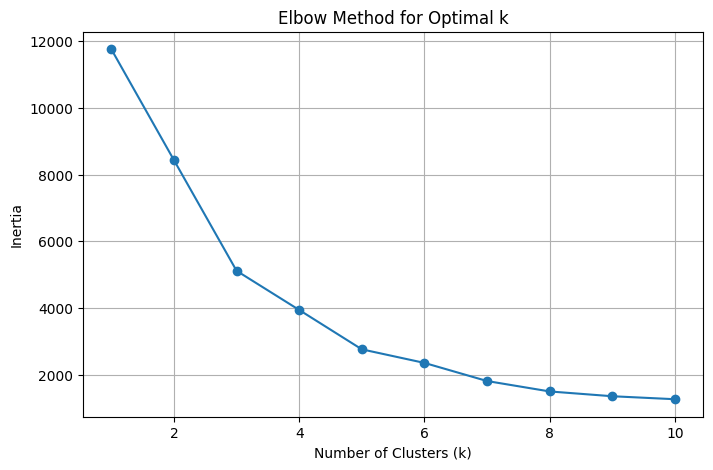

Silhouette Score for k=4: 0.600

Cluster Summary (Average RFM values and customer count per cluster):
            Recency  Frequency      Monetary  Count
Cluster                                            
0        246.623701   1.559252    437.937402    962
1         44.334089   3.328042   1139.251294   2646
2         18.782609  59.913043  71494.413043     23
3         16.044983  17.169550   7710.260727    289


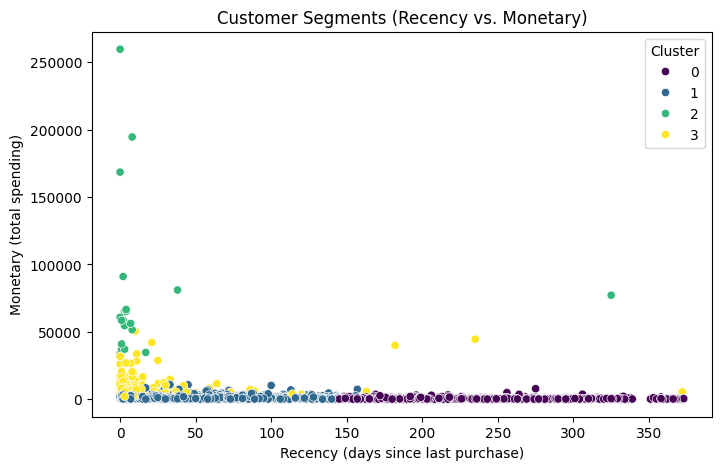

In [31]:
# Step 4: K-Means Clustering

# 1. Use the Elbow Method to determine the optimal number of clusters
# Prepare the scaled RFM data (excluding CustomerID)
rfm_features = rfm[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']]

# Calculate inertia (within-cluster sum of squares) for different k values
inertia = []
k_range = range(1, 11)  # Test k from 1 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# 2. Apply K-Means with k=4 (as specified in the report)
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_features)

# 3. Validate clustering with Silhouette score
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(rfm_features, rfm['Cluster'])
print(f"Silhouette Score for k={k_optimal}: {sil_score:.3f}")

# 4. Inspect the results
# Group by cluster to see average RFM values per cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'})
print("\nCluster Summary (Average RFM values and customer count per cluster):")
print(cluster_summary)

# Optional: Visualize cluster distribution (e.g., Recency vs. Monetary)
plt.figure(figsize=(8, 5))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Customer Segments (Recency vs. Monetary)')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Monetary (total spending)')
plt.savefig('../output/kmeans_scatter.png')
plt.show()


#### 5.2 Hierarchical Clustering

Scaled RFM Data Summary:
       Recency_scaled  Frequency_scaled  Monetary_scaled
count    3.920000e+03      3.920000e+03     3.920000e+03
mean     6.344132e-17      5.981610e-17     3.443957e-17
std      1.000128e+00      1.000128e+00     1.000128e+00
min     -9.218385e-01     -4.510003e-01    -2.486861e-01
25%     -7.510199e-01     -4.510003e-01    -2.090530e-01
50%     -4.194309e-01     -3.120783e-01    -1.620059e-01
75%      5.049991e-01      1.046876e-01    -3.846644e-02
max      2.826122e+00      2.844478e+01     3.445571e+01

NaN values in scaled data: Recency_scaled      0
Frequency_scaled    0
Monetary_scaled     0
dtype: int64
Infinite values in scaled data: Recency_scaled      0
Frequency_scaled    0
Monetary_scaled     0
dtype: int64


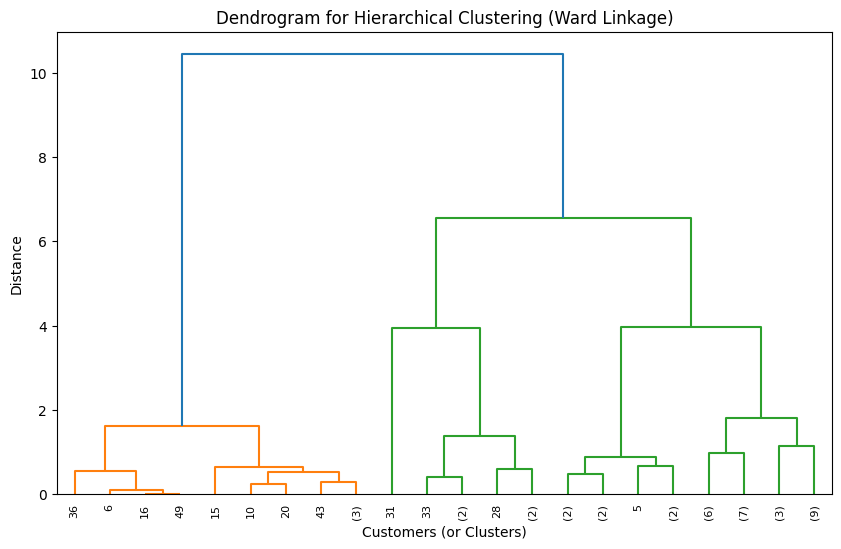


Hierarchical Cluster Summary (Average RFM values and customer count):
                         Recency  Frequency       Monetary  Count
Hierarchical_Cluster                                             
0                      14.412500  27.187500   16106.237875    160
1                     277.330396   1.443465     422.412131    681
2                      54.763654   3.642718    1242.213993   3076
3                       2.666667  36.000000  207560.196667      3

K-Means Cluster Summary (for comparison):
            Recency  Frequency      Monetary  Count
Cluster                                            
0        246.623701   1.559252    437.937402    962
1         44.334089   3.328042   1139.251294   2646
2         18.782609  59.913043  71494.413043     23
3         16.044983  17.169550   7710.260727    289


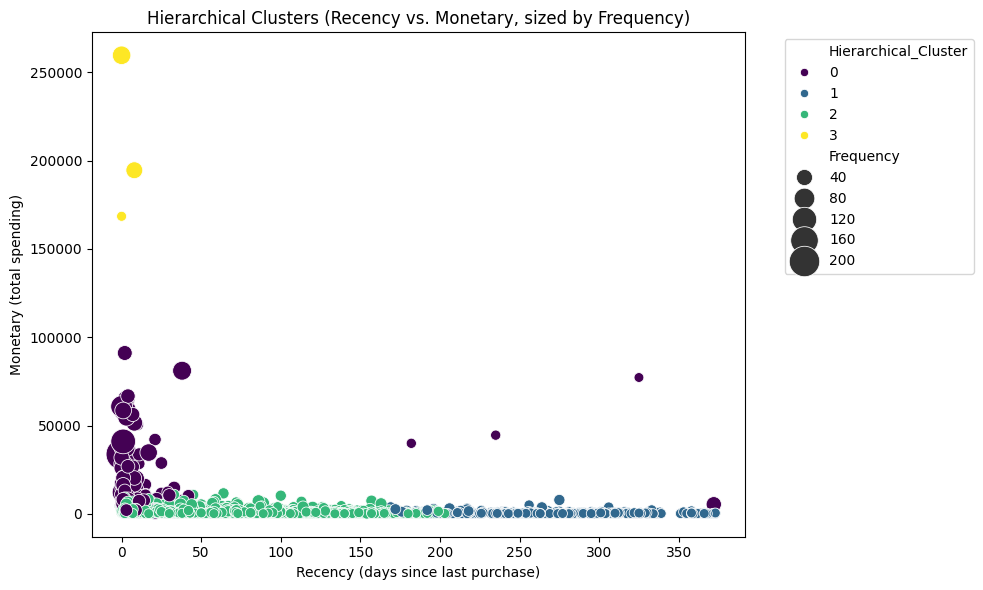

In [32]:
# Step 5: Hierarchical Clustering (Fixed)

# 1. Prepare the scaled RFM data
rfm_features = rfm[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']]

# 2. Check for outliers or invalid values in scaled data
print("Scaled RFM Data Summary:")
print(rfm_features.describe())
# Check for NaN or infinite values
print("\nNaN values in scaled data:", rfm_features.isna().sum())
print("Infinite values in scaled data:", np.isinf(rfm_features).sum())

# 3. Apply Agglomerative Clustering with k=4
agg_clustering = AgglomerativeClustering(n_clusters=4, linkage='ward')
rfm['Hierarchical_Cluster'] = agg_clustering.fit_predict(rfm_features)

# 4. Create a dendrogram with a corrected subset
subset_size = 50  # Reduced size for clarity and to avoid computational issues
np.random.seed(42)  # For reproducibility
subset_indices = np.random.choice(rfm_features.index, size=subset_size, replace=False)
rfm_features_subset = rfm_features.loc[subset_indices]  # Corrected line

# Compute the linkage matrix for the dendrogram
linked = linkage(rfm_features_subset, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linked, truncate_mode='level', p=4, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrogram for Hierarchical Clustering (Ward Linkage)')
plt.xlabel('Customers (or Clusters)')
plt.ylabel('Distance')
plt.savefig('../output/dendrogram.png')
plt.show()


# 5. Summarize hierarchical clusters
hierarchical_summary = rfm.groupby('Hierarchical_Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'})
print("\nHierarchical Cluster Summary (Average RFM values and customer count):")
print(hierarchical_summary)

# 6. Compare with K-Means clusters
print("\nK-Means Cluster Summary (for comparison):")
print(cluster_summary)

# 7. Visualize hierarchical clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Hierarchical_Cluster', palette='viridis', size='Frequency', sizes=(50, 500))
plt.title('Hierarchical Clusters (Recency vs. Monetary, sized by Frequency)')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Monetary (total spending)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




### 6. Identified customer segments


Segment Summary (Average RFM values and customer count):
                      Recency  Frequency      Monetary  Count
Segment                                                      
Loyal Customers     18.782609  59.913043  71494.413043     23
New Customers       16.044983  17.169550   7710.260727    289
Occasional Buyers   44.334089   3.328042   1139.251294   2646
At-Risk Customers  246.623701   1.559252    437.937402    962

Marketing Recommendations:
- Loyal Customers: Offer loyalty rewards, exclusive deals to maintain engagement.
- At-Risk Customers: Send win-back emails, personalized offers to re-engage.
- Occasional Buyers: Provide reminders, offer discounts on related items to boost frequency.
- New Customers: Welcome offers, guided onboarding to encourage repeat purchases.


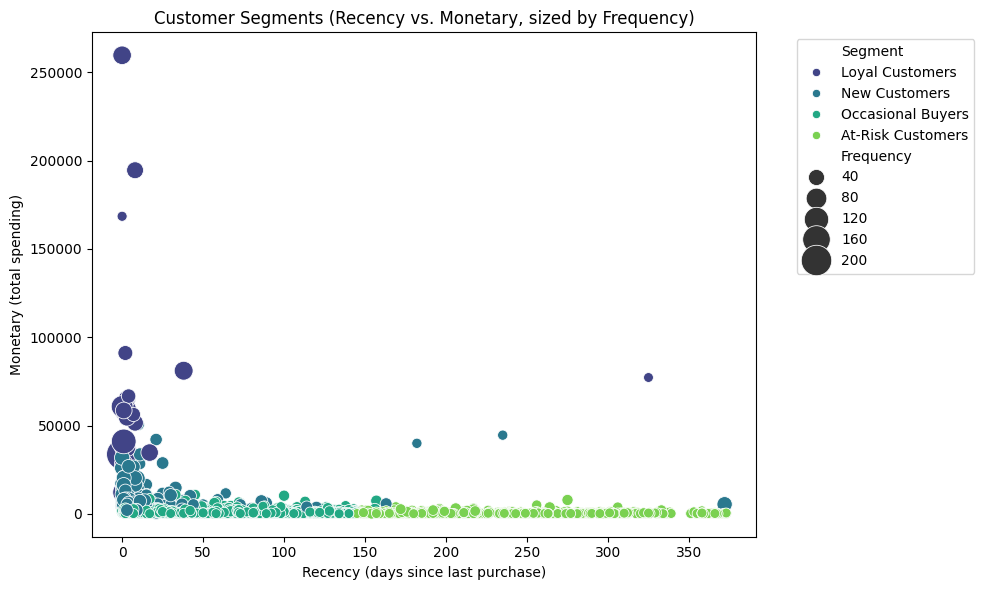


RFM data saved to rfm_data.csv


In [25]:
# Step 6: Finalizing Segments and Recommendations

# 1. Map clusters to segments based on RFM characteristics
# Using K-Means clusters as the primary segmentation (report specifies k=4 validated by both methods)
# Mapping based on previous interpretation (adjust if hierarchical clusters differ significantly):
segment_mapping = {
    0: 'At-Risk Customers',    # High Recency, low Frequency/Monetary
    1: 'Occasional Buyers',    # Moderate Recency, moderate Frequency/Monetary
    2: 'Loyal Customers',      # Low Recency, high Frequency, high Monetary
    3: 'New Customers'         # Low Recency, moderate Frequency/Monetary
}

# Assign segment labels to K-Means clusters
rfm['Segment'] = rfm['Cluster'].map(segment_mapping)

# Verify with Hierarchical clusters (optional cross-check)
rfm['Hierarchical_Segment'] = rfm['Hierarchical_Cluster'].map(segment_mapping)

# 2. Summarize segments (using K-Means clusters)
segment_summary = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).sort_values(by='Monetary', ascending=False)
print("\nSegment Summary (Average RFM values and customer count):")
print(segment_summary)

# 3. Marketing Recommendations (manual output based on report Section 8)
print("\nMarketing Recommendations:")
print("- Loyal Customers: Offer loyalty rewards, exclusive deals to maintain engagement.")
print("- At-Risk Customers: Send win-back emails, personalized offers to re-engage.")
print("- Occasional Buyers: Provide reminders, offer discounts on related items to boost frequency.")
print("- New Customers: Welcome offers, guided onboarding to encourage repeat purchases.")

# 4. Optional: Visualize segment distribution (Recency vs. Monetary)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment', palette='viridis', size='Frequency', sizes=(50, 500))
plt.title('Customer Segments (Recency vs. Monetary, sized by Frequency)')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Monetary (total spending)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save RFM data to CSV for dashboard use
rfm.to_csv('../data/rfm_data.csv', index=False)
print("\nRFM data saved to rfm_data.csv")


### 7. Creating Dashboard

2025-07-19 10:38:12.124 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-19 10:38:12.173 
  command:

    streamlit run /Users/firojshaikh/Documents/1. Projects/MSDS-555-1-BigDataMgmt&Analytics/cust-seg-for-retail-strategy/cust-seg-py311-env/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-07-19 10:38:12.175 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-19 10:38:12.175 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-19 10:38:12.176 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-19 10:38:12.176 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-19 10:38:12.177 Thread 'MainThread': missing ScriptRunCon

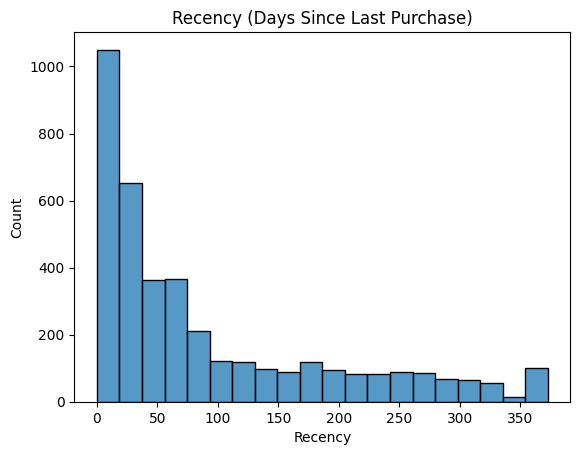

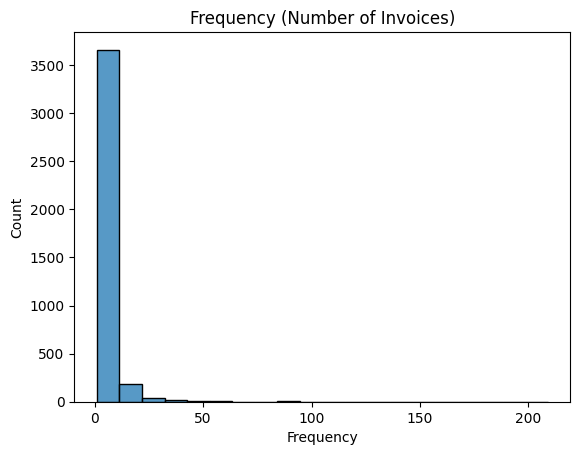

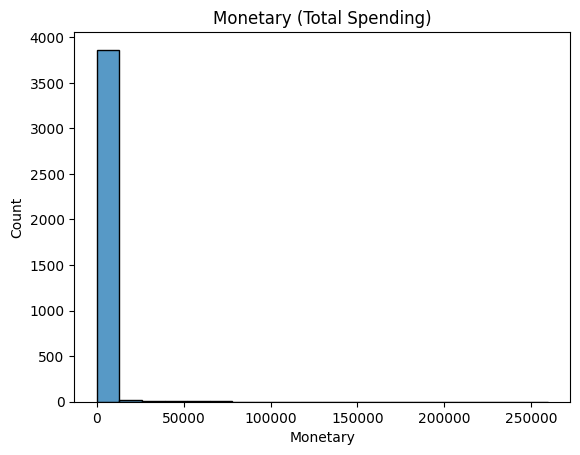

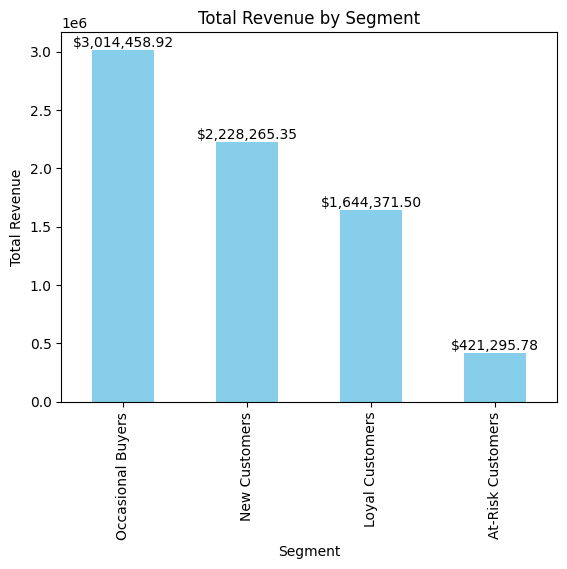

In [ ]:
# Step 7: Creating the Streamlit Dashboard
# Save this code in a file named 'dashboard.py' and run it with 'streamlit run dashboard.py'

import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the RFM DataFrame (ensure rfm is available from previous steps)
# For this example, assume rfm is already computed; in a real app, you might load it from a file
# e.g., rfm = pd.read_csv('rfm_data.csv') if saved earlier

# Title of the dashboard
st.title("Customer Segmentation Dashboard")

# 1. Visualize RFM Distributions
st.header("RFM Distributions")
col1, col2, col3 = st.columns(3)
with col1:
    st.subheader("Recency Distribution")
    fig1, ax1 = plt.subplots()
    sns.histplot(data=rfm, x='Recency', bins=20, ax=ax1)
    ax1.set_title("Recency (Days Since Last Purchase)")
    st.pyplot(fig1)

with col2:
    st.subheader("Frequency Distribution")
    fig2, ax2 = plt.subplots()
    sns.histplot(data=rfm, x='Frequency', bins=20, ax=ax2)
    ax2.set_title("Frequency (Number of Invoices)")
    st.pyplot(fig2)

with col3:
    st.subheader("Monetary Distribution")
    fig3, ax3 = plt.subplots()
    sns.histplot(data=rfm, x='Monetary', bins=20, ax=ax3)
    ax3.set_title("Monetary (Total Spending)")
    st.pyplot(fig3)

# 2. Display Cluster Sizes and Attributes
st.header("Segment Sizes and Attributes")
segment_summary = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).sort_values(by='Monetary', ascending=False)
st.table(segment_summary)

# 3. Show Revenue by Segment
st.header("Revenue by Segment")
revenue_by_segment = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)
fig4, ax4 = plt.subplots()
revenue_by_segment.plot(kind='bar', ax=ax4, color='skyblue')
ax4.set_title("Total Revenue by Segment")
ax4.set_xlabel("Segment")
ax4.set_ylabel("Total Revenue")
for i, v in enumerate(revenue_by_segment):
    ax4.text(i, v, f'${v:,.2f}', ha='center', va='bottom')
st.pyplot(fig4)

# 4. Include Marketing Recommendations
st.header("Marketing Recommendations")
st.write("- **Loyal Customers**: Offer loyalty rewards, exclusive deals to maintain engagement.")
st.write("- **At-Risk Customers**: Send win-back emails, personalized offers to re-engage.")
st.write("- **Occasional Buyers**: Provide reminders, offer discounts on related items to boost frequency.")
st.write("- **New Customers**: Welcome offers, guided onboarding to encourage repeat purchases.")


In [ ]:
# Step 7: Creating the Streamlit Dashboard with Custom Colors
# Save this code in a file named 'dashboard.py' and run it with 'streamlit run dashboard.py'

import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the RFM DataFrame (ensure rfm is available from previous steps)
# For this example, assume rfm is already computed; in a real app, load it if saved
# e.g., rfm = pd.read_csv('rfm_data.csv') if saved earlier

# Title of the dashboard
st.title("Customer Segmentation Dashboard")

# Custom color palette for visualizations
custom_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']  # Distinct colors: Red, Teal, Blue, Green
segment_colors = {
    'Loyal Customers': '#FF6B6B',    # Red
    'At-Risk Customers': '#4ECDC4',  # Teal
    'Occasional Buyers': '#45B7D1',  # Blue
    'New Customers': '#96CEB4'       # Green
}

# 1. Visualize RFM Distributions with Custom Colors
st.header("RFM Distributions")
col1, col2, col3 = st.columns(3)
with col1:
    st.subheader("Recency Distribution")
    fig1, ax1 = plt.subplots()
    sns.histplot(data=rfm, x='Recency', bins=20, color=custom_colors[0], ax=ax1)  # Red
    ax1.set_title("Recency (Days Since Last Purchase)")
    st.pyplot(fig1)

with col2:
    st.subheader("Frequency Distribution")
    fig2, ax2 = plt.subplots()
    sns.histplot(data=rfm, x='Frequency', bins=20, color=custom_colors[1], ax=ax2)  # Teal
    ax2.set_title("Frequency (Number of Invoices)")
    st.pyplot(fig2)

with col3:
    st.subheader("Monetary Distribution")
    fig3, ax3 = plt.subplots()
    sns.histplot(data=rfm, x='Monetary', bins=20, color=custom_colors[2], ax=ax3)  # Blue
    ax3.set_title("Monetary (Total Spending)")
    st.pyplot(fig3)

# 2. Display Cluster Sizes and Attributes
st.header("Segment Sizes and Attributes")
segment_summary = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).sort_values(by='Monetary', ascending=False)
st.table(segment_summary)

# 3. Show Revenue by Segment with Custom Colors
st.header("Revenue by Segment")
revenue_by_segment = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)
fig4, ax4 = plt.subplots()
bars = revenue_by_segment.plot(kind='bar', ax=ax4, color=[segment_colors[seg] for seg in revenue_by_segment.index])
ax4.set_title("Total Revenue by Segment")
ax4.set_xlabel("Segment")
ax4.set_ylabel("Total Revenue")
for i, v in enumerate(revenue_by_segment):
    ax4.text(i, v, f'${v:,.2f}', ha='center', va='bottom', color='black')
st.pyplot(fig4)

# 4. Include Marketing Recommendations
st.header("Marketing Recommendations")
st.write("- **Loyal Customers**: Offer loyalty rewards, exclusive deals to maintain engagement.")
st.write("- **At-Risk Customers**: Send win-back emails, personalized offers to re-engage.")
st.write("- **Occasional Buyers**: Provide reminders, offer discounts on related items to boost frequency.")
st.write("- **New Customers**: Welcome offers, guided onboarding to encourage repeat purchases.")


2025-07-19 10:40:49.932 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-19 10:40:49.933 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-19 10:40:49.933 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-19 10:40:49.933 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-19 10:40:49.934 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-19 10:40:49.934 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-19 10:40:49.935 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-19 10:40:49.935 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar